<a href="https://colab.research.google.com/github/omar907/Puplic-Figures-Face-recognition/blob/master/Puplic_Figures_Face_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Face recognition using neural network features

In this task, you have to construct face recognizer based on features extracted from the neural network. The task consists of two parts: image classification and video classification. In the first one you should classify distinct images and in the second one you will deal with short video sequences.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!pip install tensorflow==2

     |████████████████████████████████| 86.3MB 36kB/s 
     |████████████████████████████████| 3.8MB 34.9MB/s 
     |████████████████████████████████| 450kB 44.4MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=4c7a79225f9600d1f8ce58de6accc9f6734de58c4b1c01397d23b553c50023cd
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.10.0rc0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorboard 2.2.1
    Uninstalling tensorboard-2.2.1:
      Successfully uninstalled tensorboard-2.2.1
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0
  Found existing installation

In [ ]:
import numpy as np
import pandas as pd
import os

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.pyplot import figure
import matplotlib.lines as mlines
from matplotlib import image, patches

import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Activation, concatenate
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, Lambda, LeakyReLU
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras.utils import np_utils

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import f1_score, classification_report, confusion_matrix

import skimage
from skimage.io import imread, imshow, imsave
from skimage import transform
from skimage.transform import resize
from skimage.color import rgb2gray, gray2rgb

import scipy
from scipy.io import  loadmat

import seaborn as sn

import h5py
import pickle
import math
import time
from time import time, sleep
from copy import deepcopy
import random
from shutil import move, copy
from zipfile import ZipFile

import cv2

# Tensorboard
from tensorflow.keras.callbacks import TensorBoard
# Load the TensorBoard notebook extension
%load_ext tensorboard

from IPython.display import clear_output

tf.__version__

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


'2.0.0'

In [ ]:
#%cd /content/drive/My Drive/Machine Learning/Deep Leaning on Computer vision course/Week 4/face-recognition-task
#from get_data import unpack
#unpack('Face_Recognition_data.zip')

In [ ]:
%cd /content/drive/My Drive/Machine Learning/Deep Leaning on Computer vision course/Week 4

#from graph import show_bboxes

def show_bboxes(bboxes, ax, color="black", text=None):
    for i, bbox in enumerate(bboxes):
        ax.add_patch(patches.Rectangle((bbox[1], bbox[0]), bbox[3] - bbox[1], bbox[2] - bbox[0], fill=False, color=color))
        if text is not None:
            ax.text(bbox[1], bbox[0], text[i], color=color)
 


def visualize_bboxes1(images, pred_bboxes=None, decision_function=None, n_cols=5, n_rows=1):
    plt.figure(figsize = (3*n_cols,3*n_rows))
    
    if pred_bboxes is not None:
        pred_bboxes = np.array(pred_bboxes, dtype=np.int32)
    #if true_bboxes is not None:
    #    true_bboxes = np.array(true_bboxes, dtype=np.int32)

    for n,i in enumerate(range(n_cols)):
        ax = plt.subplot(n_rows,n_cols,n+1)
        plt.axis('off')
        plt.imshow(images[i])

        if pred_bboxes is not None:
            _text = (["{0:0.2f}".format(decision_function[prec]) for prec in np.where(pred_bboxes[:, 0] == i)[0]]
                     if decision_function is not None else None)
            show_bboxes(bboxes=pred_bboxes[pred_bboxes[:, 0] == i, 1:], ax=ax, color="blue", text=_text)
        
        #if true_bboxes is not None:
        #    show_bboxes(bboxes=true_bboxes[true_bboxes[:, 0] == i, 1:], ax=ax, color="red")
    plt.show()

/content/drive/My Drive/Machine Learning/Deep Leaning on Computer vision course/Week 4


First of all, you have you have to read the data. Run the cell below to unpack data.

In [ ]:
# Load data from the pickle files
%cd /content/drive/My Drive/Machine Learning/Deep Leaning on Computer vision course/Week 4

with open('train_images.pickle', 'rb') as f:
    x_train, y_train = pickle.load(f)

with open('test_images.pickle', 'rb') as f:
    x_test, y_test = pickle.load(f)

with open('train_videos.pickle', 'rb') as f:
    video_train, train_labels = pickle.load(f)

with open('test_videos.pickle', 'rb') as f:
    video_test, test_labels = pickle.load(f)

/content/drive/My Drive/Machine Learning/Deep Leaning on Computer vision course/Week 4


In [ ]:
def visualize(data, labels, function = lambda x:x[0], n_cols = 5, n_rows=1):
    figure(figsize = (3*n_cols,3*n_rows))
    for n,i in enumerate(np.random.choice(list(data.keys()), size = n_cols*n_rows)):
        plt.subplot(n_rows,n_cols,n+1)
        plt.axis('off')
        plt.imshow(function([data[i]]))
        plt.title(labels[i])
    plt.show()

### Reading data for image and video classification

Implement function $\tt{load}$\_$\tt{image}$\_$\tt{data}$. It should return a tuple of 4 dictionaries: the first two are training images and labels, the second two are testing ones. The keys of the dictionaries are the names of the image files and the values are 3-dimensional numpy arrays (for images) or strings with the names (for labels).

$\tt{dir}$\_$\tt{name}$ is the name of directory with data for image classification. If 'Face_Recofnition_data' directory is located in the same directory as this notebook, then the default value can be used.

In [ ]:
def load_image_data(dir_name = '/content/drive/My Drive/Machine Learning/Deep Leaning on Computer vision course/Week 4/face-recognition-task/Face_Recognition_data/image_classification'):
  """Your implementation"""
  # Return a tuple of 4 dictionaries (train images, train labels, test images, test labels)
  train_dir = os.path.join(dir_name, 'train')
  test_dir = os.path.join(dir_name, 'test')

  df_y_train = pd.read_csv(os.path.join(train_dir, 'y_train.csv'))
  df_y_test = pd.read_csv(os.path.join(test_dir, 'y_test.csv'))


  X_train_dec = {img_name: imread(train_dir+'/images/'+img_name) for img_name in df_y_train.iloc[:,0]}
  y_train_dec = {img_name: df_y_train.iloc[i,1] for i, img_name in enumerate(df_y_train.iloc[:,0])}
  
  X_test_dec = {img_name: imread(test_dir+'/images/'+img_name) for img_name in df_y_test.iloc[:,0]}
  y_test_dec = {img_name: df_y_test.iloc[i,1] for i, img_name in enumerate(df_y_test.iloc[:,0])}


  return (X_train_dec, y_train_dec, X_test_dec, y_test_dec)

In [ ]:
#x_train, y_train, x_test, y_test = load_image_data()
print(len(x_train), '\ttraining images')
print(len(x_test), '\ttesting images')

661 	training images
808 	testing images


In [ ]:
#with open('train_images.pickle', 'wb') as f:
#    pickle.dump([x_train, y_train], f)

#with open('test_images.pickle', 'wb') as f:
#    pickle.dump([x_test, y_test], f)   

That is how the data looks like.

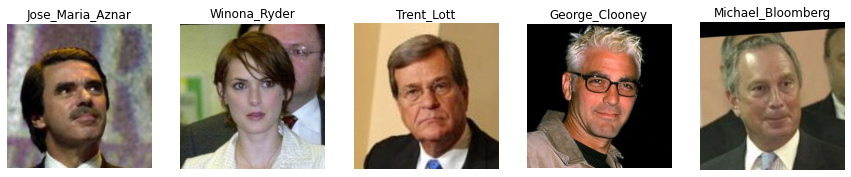

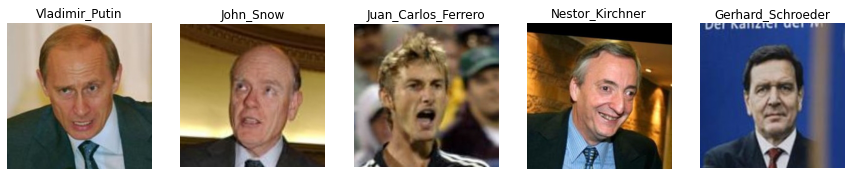

In [ ]:
visualize(x_train, y_train)
visualize(x_test, y_test)

Let us now read the video classification data, as well. You have to implement function to load video data.

Function $\tt{load}$\_$\tt{video}$\_$\tt{data}$ should also return a tuple of 4 dictionaries: the first two are training images and labels, the second two are testing videos and labels. The training data is in the same format as in image classification task. The keys of testing data and labels are video ids and the values are the lists of frames and the strings with names, respectively.

In [ ]:
def load_video_data(dir_name = '/content/drive/My Drive/Machine Learning/Deep Leaning on Computer vision course/Week 4/face-recognition-task/Face_Recognition_data/video_classification'):
    """Your implementation"""
    # Return a tuple of 4 dictionaries (train images, train labels, test images, test labels)
    train_dir = os.path.join(dir_name, 'train')
    test_dir = os.path.join(dir_name, 'test')
    
    df_y_train = pd.read_csv(os.path.join(train_dir, 'y_train.csv'))
    df_y_test = pd.read_csv(os.path.join(test_dir, 'y_test.csv'))

    X_test_dec, y_test_dec = {}, {}
    
    for i, video_id in enumerate(df_y_test.iloc[:,0]):
      frames = []
      for frame_name in os.listdir(test_dir+'/videos/'+str(video_id)):
        frames.append(imread(test_dir+'/videos/'+str(video_id)+'/'+frame_name))
      X_test_dec[video_id] = frames
      y_test_dec[video_id] = df_y_test.iloc[i,1]


    X_train_dec = {img_name: imread(train_dir+'/images/'+img_name) for img_name in df_y_train.iloc[:,0]}
    y_train_dec = {img_name: df_y_train.iloc[i,1] for i, img_name in enumerate(df_y_train.iloc[:,0])}
    
    
    return (X_test_dec, y_test_dec)

In [ ]:
#video_test, test_labels = load_video_data()
print(len(video_train), '\ttraining images')
print(len(video_test), '\ttesting videos')

729 	training images
70 	testing videos


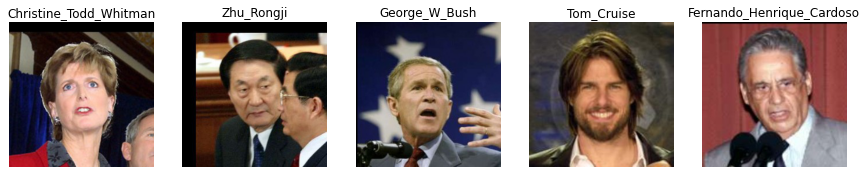

In [ ]:
visualize(video_train, train_labels)

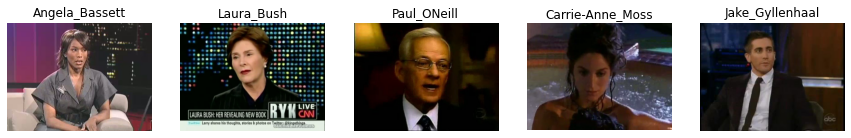

In [ ]:
visualize({i:video_test[i][0] for i in video_test}, test_labels)

In [ ]:
# Creating Pickle files
#%cd /content/drive/My Drive/Machine Learning/Deep Leaning on Computer vision course/Week 4

#with open('train_videos.pickle', 'wb') as f:
#    pickle.dump([video_train, train_labels], f)
#with open('test_videos.pickle', 'wb') as f:
#    pickle.dump([video_test, test_labels], f)   

### Preprocessing
You have to implement preprocessing function in the cell below.
Getting a list of images as an input the this function should detect the face on each image, find the facial keypoints () and then crop and normalize the image according to these keypoints. The output of this function is the list of images which contain only the aligned face and should be converted to the tensor of the shape $(N, 224, 224, 3)\ $ where $N$ is the length of the initial list. You can add extra arguments to the preprocess function if necessary (i.e. flag $\tt{is}$\_$\tt{video}$ to determine if the list of images is video sequence or not).

For face detection and facial keypoint regression you can use your models from the previous tasks.

In [ ]:
%cd /content/drive/My Drive/Machine Learning/Deep Leaning on Computer vision course/Week 4/face-recognition-task

/content/drive/My Drive/Machine Learning/Deep Leaning on Computer vision course/Week 4/face-recognition-task


In [ ]:
from keras.preprocessing.image import ImageDataGenerator # Usefull thing. Read the doc.

datagen = ImageDataGenerator(horizontal_flip=True,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             zoom_range=0.1,
                             samplewise_center = True,
                             samplewise_std_normalization = True
                            )
#datagen.fit(X_train)

In [ ]:
face_detection_model = load_model('/content/drive/My Drive/Machine Learning/Deep Leaning on Computer vision course/Week 4/face-recognition-task/fcnn_Detector_Net_model.h5')
#face_detection_model.summary()

In [ ]:
# Detection
from skimage.feature import peak_local_max
IMAGE_SHAPE = (224, 224, 3)

def get_bboxes_and_decision_function(fcnn_model, images):      
    cropped_images = np.array([resize(image, IMAGE_SHAPE, mode="reflect")  if image.shape != IMAGE_SHAPE else image for image in images])
    pred_bboxes, decision_function = [], []
   
    # Predict
    #predictions = face_detection_model(resized1, training=False)
    predictions = fcnn_model.predict(datagen.standardize(np.asarray(cropped_images,dtype='float')))
    img_shape = np.array([224,224])
    
    # Write code here
    for i in range(len(predictions)):
        local_max_list = peak_local_max(predictions[i][:,:,1], num_peaks=5, min_distance=3, exclude_border=False)
        for local_max_orig in local_max_list:
            local_max = ((local_max_orig + 2)*224/49).astype(int)
            
            if local_max[0] < img_shape[0] and local_max[1] < img_shape[1]:
                bbox = [i] + [local_max[0]-16,local_max[1]-16,local_max[0]+16,local_max[1]+16]
                
                pred_bboxes.append(bbox)
                decision_function.append(predictions[i, local_max_orig[0], local_max_orig[1], 1])
        
    return pred_bboxes, decision_function

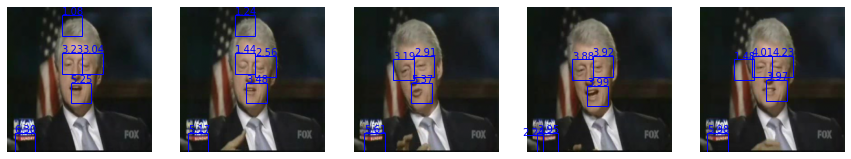

In [ ]:
#imgs = [x_train[str(i)+'.jpg'] for i in range(6,12)]
imgs = video_test[17][:5]
dim_detector = (224, 224)
r=[]


for img in imgs:
  r.append(resize(img, dim_detector, anti_aliasing=True))

#print(r[0].shape)
#plt.imshow(img)


pred_bboxes, decision_function = get_bboxes_and_decision_function(
    fcnn_model=face_detection_model,
    images=r
    )

visualize_bboxes1(images=r,
                  pred_bboxes=pred_bboxes,
                  decision_function=decision_function,
                  n_cols=5
                )

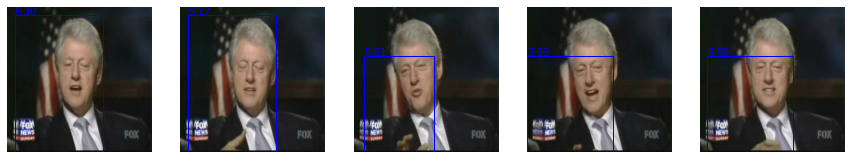

In [ ]:
final_bboxes = []
final_decision = []
p = np.array(pred_bboxes)
d = np.array(decision_function)

for i in range(p[-1,0]+1):
  mask = np.logical_and(p[:,0]==i, d>1.0)
  bbox = [i, np.maximum(p[mask,1].min(), 0), 
          np.maximum(p[mask,2].min(), 0),
          np.maximum(p[mask,3].max(), 0),
          np.maximum(p[mask,4].max(), 0)]
          
  max_dec = d[p[:,0]==i].max()
  final_bboxes.append(bbox)
  final_decision.append(max_dec)


visualize_bboxes1(r, pred_bboxes=final_bboxes, decision_function=final_decision, n_cols=5, n_rows=1)


In [ ]:
# Croping the bounding box
print(final_bboxes)
print(final_decision)

[[0, 11, 11, 226, 148], [1, 11, 11, 226, 148], [2, 75, 16, 226, 125], [3, 75, 0, 230, 134], [4, 75, 11, 226, 144]]
[6.302663, 5.1652594, 5.6113057, 3.9879093, 5.978374]


In [ ]:
croped_images = []
for i in range(len(r)):
  croped_images.append(resize(r[i]
                              [np.maximum(final_bboxes[i][1]-20, 0):
                              np.maximum(final_bboxes[i][3]+20, 0), 
                               np.maximum(final_bboxes[i][2]-20, 0):
                               np.maximum(final_bboxes[i][4]+20, 0)], (100,100)))


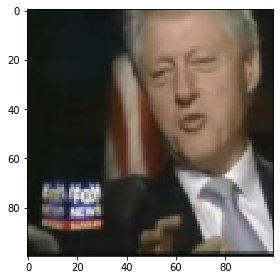

In [ ]:
imshow(croped_images[2])

In [ ]:
# where is 2 function, which do transformations [(x1, y1), (x2, y2),..] <-> [x1, y1, x2, y2,..]
def pack_points(list_of_point):
    assert len(list_of_point)%2 == 0, 'Len of list should be even'
    n = int(len(list_of_point)/2)
    
    packed_points = [(list_of_point[2*i], list_of_point[2*i+1]) for i in range(n)]
    return packed_points

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

def visualize_points(img, points):
    plt.imshow(img)
    fig = plt.gcf()
    ax = fig.gca()
    points = pack_points(points)
    for point in points:
        circle = plt.Circle(((point[0]+0.5)*img.shape[1], (point[1]+0.5)*img.shape[0]), 0.7, color='r')
        ax.add_artist(circle)
        
#n = 27
#visualize_points(imgs[n], points[n])

In [ ]:
def transform_face(image, eyes):
    """ Your implementation """
    diff =  np.asarray(eyes[1]) - np.asarray(eyes[0])
    theta = np.arctan( diff[1] / diff[0] )
    
    #deg = theta*180/np.pi
    #rotated = skimage.transform.rotate(image, deg)
    
    
    x_new1 = np.asarray(eyes[0])[1] *np.sin(theta) + np.asarray(eyes[0])[0]*np.cos(theta)
    y_new1 = np.asarray(eyes[0])[1] *np.cos(theta) - np.asarray(eyes[0])[0]*np.sin(theta)
    
    x_new2 = np.asarray(eyes[1])[1] *np.sin(theta) + np.asarray(eyes[1])[0]*np.cos(theta)
    y_new2 = np.asarray(eyes[1])[1] *np.cos(theta) - np.asarray(eyes[1])[0]*np.sin(theta)
    
    eyes_new = np.array([[x_new1,y_new1],[x_new2,y_new2]],dtype = np.int32)
    
    
    
    top_left = [eyes_new[0,:][0] - 0 , eyes_new[0,:][1] - 0 ] 
    button_right = [eyes_new[1,:][0] + 170 , eyes_new[1,:][1] + 170 ]
    
    for j in range(2):
        if top_left[j] < 0:
            top_left[j] = 0
        if button_right[j] < 0:
            button_right[j] = 0
    
    cropped = image[top_left[1]:button_right[1],top_left[0]:button_right[0]]
    
    resized = skimage.transform.resize(cropped, (224,224,3))
    
    return resized

In [ ]:
def preprocess_imgs(imgs, is_video=False, frame_freq=1):
    """Your implementation"""
    #face_detection_model = load_model('fcnn_Detector_Net_model.h5')
    facial_keypoints_model = load_model('week2_model.h5')

    dim_detector = (224, 224)
    dim_facial_keypoints = (100,100)

    if(is_video==False):
      frame_freq=1

    counter=0
    Output_imgs_list = []
    #keypoints_list = []
    ## Gitting the output of the detecor and the keypoints models
    for img in imgs[::frame_freq]:
      # resize image
      Output_image = resize(img, dim_detector)
      keypoints_resized = resize(img, dim_facial_keypoints)
      
      keypoints_resized = np.expand_dims(keypoints_resized, axis=0)

      keypoints = facial_keypoints_model.predict(keypoints_resized) ########

      keypoints *= (224/100)
      keypoints = keypoints

      points = pack_points(keypoints[0])
      
      Output_image = transform_face(Output_image, (points[5], points[8]))

      Output_imgs_list.append(Output_image)
    
    return np.array(Output_imgs_list)

#### Visualization of preprocessing

In [ ]:
#preprocessed_x_train = preprocess_imgs(np.array([video_train['0.jpg'], video_train['1.jpg'], video_train['10.jpg']]))
preprocessed_x_train = preprocess_imgs(video_test[56], is_video=True, frame_freq=25)

preprocessed_x_train.shape

(5, 224, 224, 3)

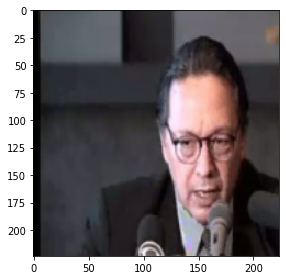

In [ ]:
imshow(preprocessed_x_train[4])

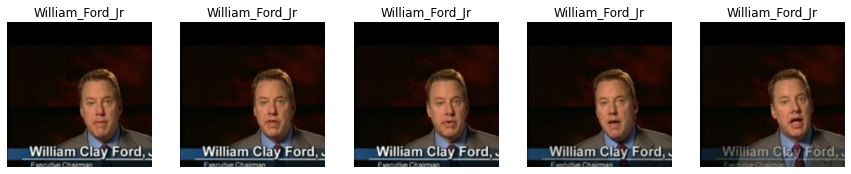

In [ ]:
key = 21
visualize({i:video_test[key][i] for i in range(len(video_test[key]))}, 
          {i: test_labels[key] for i in range(len(video_test[key]))}, 
          function = lambda x:preprocess_imgs(x)[0])

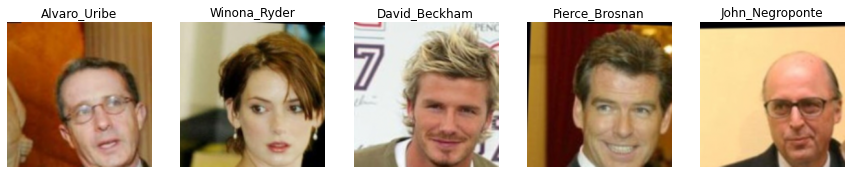

In [ ]:
visualize(x_train, y_train, function = lambda x:preprocess_imgs(x)[0])

The neural network is already trained on the other face dataset. You should use this network as feature extractor to get descriptors of the faces. You can choose any hidden layer you need (or several layers) to extract features and any classification method.

In [ ]:
!# Unzip Files
#%cd /content/drive/My Drive/Machine Learning/Deep Leaning on Computer vision course/Week 4/face-recognition-task
#file_name = 'face_recognition_model.rar'

#with ZipFile(file_name,'r') as zip:
#  zip.extractall()
#  print('Done')

In [ ]:
%cd /content/drive/My Drive/Machine Learning/Deep Leaning on Computer vision course/Week 4/face-recognition-task
model = load_model('no_model_face_recognition_model.h5')
model.summary()

/content/drive/My Drive/Machine Learning/Deep Leaning on Computer vision course/Week 4/face-recognition-task
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0         
_____________

Here is an example of using the network as feature extractor. The shape of input tensor has to be (n_images, 224, 224, 3), so you can input several images simultaneously and get their face descriptors of shape (n_images, n_components).

In [ ]:
def get_layer_output(images, layer = 'fc6'):
    assert len(images.shape)==4, 'Wrong input dimentionality!'
    assert images.shape[1:]==(224,224,3), 'Wrong input shape!'
    
    network_output = model.get_layer(layer).output
    feature_extraction_model = Model(model.input, network_output)
    
    output = feature_extraction_model.predict(images)
    return output

In [ ]:
img = cv2.resize(x_train['0.jpg'], (224,224)).reshape(1,224,224,3)
out = get_layer_output(img)
print(out.shape)

(1, 4096)


### Training classifier


You have to implement class $\tt{Classifier}$ with methods $\tt{fit}$, $\tt{classify}$\_$\tt{images}$ and $\tt{classify}$\_$\tt{videos}$ in the cell below. 
The method $\tt{Classifier.fit}$ gets two dictionaries as input: train images and labels, and trains the classifier to predict the person shown on the image.
$\tt{Classifier.classify}$\_$\tt{images}$ gets the dictionary of test images (with filenames as keys) as input and should return the dictionary of the predicted labels.
$\tt{Classifier.classify}$\_$\tt{videos}$ is similar to the previous one, but gets the dictionary of test videos (with video as keys) as input.

To classify video you can combine the predictions for its frames any way you want (averaging, voting, etc.).
If video classification takes too long you can use face detector not in all the frames but every few frames while preprocessing video frames. 
Besides, sometimes the face is hardly detected on the image and the frame in which the detector works wrong can add noise to the prediction. Hence, the result of the prediction without using such frames may be better.

In [ ]:
%cd /content/drive/My Drive/Machine Learning/Deep Leaning on Computer vision course/Week 4/face-recognition-task

/content/drive/My Drive/Machine Learning/Deep Leaning on Computer vision course/Week 4/face-recognition-task


In [ ]:
from sklearn.neighbors import KNeighborsClassifier as kNN
from skimage.io import imread
import cv2
from os.path import join
from collections import Counter
class Classifier():
    def __init__(self, nn_model):
        """Your implementation"""
        self.nn_model = nn_model
        self.KNN_model = kNN(n_neighbors=5, weights='distance')
        self.dictionary_of_lables = {}

    
    def create_feature_extractor(self, layer = 'fc6'):
      network_output = self.nn_model.get_layer(layer).output
      feature_extraction_model = Model(self.nn_model.input, network_output)
      feature_extraction_model.compile(loss='categorical_crossentropy', optimizer=Adam())
      return feature_extraction_model

    
    def fit(self, train_imgs, train_labels):
        """Your implementation"""
        X=[]
        y=[]
        # Creating X and y from the dictionary
        for i in train_imgs.keys():
          X.append(train_imgs[i])
          y.append(train_labels[i])

        X_preprocessed = preprocess_imgs(X)

        feature_extraction_model = self.create_feature_extractor()

        self.nn_model.compile(loss='categorical_crossentropy', optimizer=Adam())
        #self.nn_model.compile()
        descriptors = feature_extraction_model.predict(X_preprocessed)

        le = sklearn.preprocessing.LabelEncoder()
        labels_encoded=le.fit_transform(y)

        self.KNN_model.fit(descriptors, labels_encoded)

        y = list(dict.fromkeys(y))
        labels_encoded = list(dict.fromkeys(labels_encoded))
        y = [x for _,x in sorted(zip(labels_encoded,y))]
        labels_encoded = sorted(labels_encoded)

        self.dictionary_of_lables = {}
        for i, j in zip(labels_encoded, y):
          self.dictionary_of_lables[i] = j


    def classify_images(self, test_imgs):
        """Your implementation"""
        # test_imgs are dictionaries so we may have to deal with this.
        X_test = []
        feature_extraction_model = self.create_feature_extractor()

        for i in test_imgs.keys():
          X_test.append(test_imgs[i])

        # Creating X_test from the dictionary
        X_test = preprocess_imgs(X_test)
        
        descriptors = feature_extraction_model.predict(X_test)
        predictions = self.KNN_model.predict(descriptors)

        predictions_dictionary = {}
        for i, img_name in enumerate(test_imgs.keys()):
          predictions_dictionary[img_name] = self.dictionary_of_lables[predictions[i]]

        return predictions_dictionary
       
    
    def classify_videos(self, test_video):
      """Your implementation"""
      res = {}
      for k, v in test_video.items():
          table = Counter()
          feature_extraction_model = self.create_feature_extractor()
          for img in v:
              pre_img = preprocess_imgs([img])[0]
              pre_img = pre_img[np.newaxis, ...]
              test_img_features = feature_extraction_model.predict(pre_img)
              predicted_y = self.KNN_model.predict(test_img_features)[0]
              table[predicted_y] += 1
          res[k] = max(table, key=lambda x:table[x])

      return res


        
#    def classify_videos(self, test_video, frame_freq=10):
#        """Your implementation"""
        # test_imgs are dictionaries so we may have to deal with this.
#        predictions_dictionary = {}
#        feature_extraction_model = self.create_feature_extractor()

#        for key in test_video.keys():
#          X_test = []
#          # Creating X_test from the dictionary
#          #print(len(test_video[key]))
#          X_test = preprocess_imgs(test_video[key], is_video=True, frame_freq=frame_freq)
#          descriptors = feature_extraction_model.predict(X_test)
#          predictions = self.KNN_model.predict(descriptors)
          
          # Majority voting code
#          final_prediction=max(map(lambda val: (np.sum(predictions == val), val), set(predictions)))[-1]
          
#          predictions_dictionary[key] = self.dictionary_of_lables[final_prediction]
          
#        return predictions_dictionary

Now we can build the classifier, fit it and use to predict the labels of testing images.

In [ ]:
#img_classifier = Classifier(model)
#img_classifier.fit(x_train, y_train)
#y_out = img_classifier.classify_images(x_test)

### Image classification quality test

In [ ]:
def check_test(output, gt):
    correct = 0.
    total = len(gt)
    for k, v in gt.items():
        if output[k] == v:
            correct += 1
    accuracy = correct / total

    return 'Classification accuracy is %.4f' % accuracy

In [ ]:
print(check_test(y_out, y_test))

Classification accuracy is 0.9109


### Video classification quality test

In [ ]:
video_classifier = Classifier(model)
video_classifier.fit(video_train, train_labels)
y_video_out = video_classifier.classify_videos(video_test, frame_freq=15)

In [ ]:
print(check_test(y_video_out, test_labels))

In [ ]:
y2_out = img_classifier.classify_images(x_test_video)

In [ ]:
print(check_test(y2_out, test_labels))

Classification accuracy is 0.0286


In [ ]:
X=[]
train_labels_r=[]
# Creating X and y from the dictionary
for i in train_labels.keys():
  train_labels_r.append(train_labels[i])

le2 = sklearn.preprocessing.LabelEncoder()
labels_encoded=le2.fit_transform(train_labels_r)


train_labels_r = list(dict.fromkeys(train_labels_r))
labels_encoded = list(dict.fromkeys(labels_encoded))
train_labels_r = [x for _,x in sorted(zip(labels_encoded,train_labels_r))]
labels_encoded = sorted(labels_encoded)

dictionary_of_lables = {}
for i, j in zip(labels_encoded, train_labels_r):
  dictionary_of_lables[i] = j

In [ ]:
l = list(train_labels.values())
uni_l = np.unique(l)

In [ ]:
l2 = list(test_labels.values())
uni_l2 = np.unique(l2)
#uni_l2

In [ ]:
for i in uni_l2:
  if(i not in uni_l):
    print(i)

In [ ]:
len(list(y_video_out.keys()))

70

In [ ]:
for key in y_test.keys():
  print(y_test[key],'  ',img_classifier.dictionary_of_lables[key])

In [ ]:
for key in test_labels.keys():
  print(test_labels[key],'  ', video_classifier.dictionary_of_lables[key])

# Draft

In [ ]:
# train_imgs and train_labels are dictionaries so we may have to deal with this.
#self.nn_model.fit(
#    x = train_imgs,
#    y = train_labels,
#    batch_size=self.BS,
#    epochs=epochs,
#    verbose=1
#    )

In [ ]:
lVals = np.array([1,10,2,2,10,100000])
#print( max(map(lambda val: (lVals.count(val), val), set(lVals))) )
lVals.shape

(6,)

In [ ]:
max(map(lambda val: (np.sum(lVals == val), val), set(lVals)))[-1]

10

In [ ]:
np.sum(lVals == 10)

3

In [ ]:
for i in map(lambda val: (np.sum(lVals == val), val), set(lVals)):
  print(i)

(3, 1)
(8, 2)
(3, 3)
(13, 4)


In [ ]:
'''
def preprocess_imgs2(imgs, is_video=False, frame_freq=1):
    """Your implementation"""
    #face_detection_model = load_model('fcnn_Detector_Net_model.h5')
    facial_keypoints_model = load_model('week2_model.h5')

    dim_detector = (224, 224)
    dim_facial_keypoints = (100,100)

    detection_offset = 20 # pixel

    if(is_video==False):
      frame_freq=1

    r = imgs[::frame_freq]
    # Detector
    # Detect the faces from the images
    
    pred_bboxes, decision_function = get_bboxes_and_decision_function(
        fcnn_model=face_detection_model, 
        images=r
        )
    
    p = np.array(pred_bboxes)
    d = np.array(decision_function)

    final_pred_bboxes = []
    final_decision_function = []
    for i in range(p[-1,0]+1):
      mask = np.logical_and(p[:,0]==i, d[i]>1.0)
      
      if(mask.sum() == 0):
        continue
      
      bbox = [i, np.maximum(p[mask,1].min(), 0), 
              np.maximum(p[mask,2].min(), 0),
              np.maximum(p[mask,3].max(), 0),
              np.maximum(p[mask,4].max(), 0)]
      
      
      
      max_dec = d[p[:,0]==i].max()
      final_pred_bboxes.append(bbox)
      final_decision_function.append(max_dec)

    detected_faces = []
    for i in range(len(r)):
      detected_faces.append(resize(r[i]
                                  [np.maximum(final_bboxes[i][1]-detection_offset, 0):
                                  np.maximum(final_bboxes[i][3]+detection_offset, 0),
                                   np.maximum(final_bboxes[i][2]-detection_offset, 0):
                                   np.maximum(final_bboxes[i][4]+detection_offset, 0)], (100,100)))




    ######################
    Output_imgs_list = []
    #keypoints_list = []
    ## Gitting the output of the detecor and the keypoints models
    for img in detected_faces:
      # resize image
      Output_image = resize(img, dim_detector)
      keypoints_resized = resize(img, dim_facial_keypoints)
      
      keypoints_resized = np.expand_dims(keypoints_resized, axis=0)

      keypoints = facial_keypoints_model.predict(keypoints_resized) ########

      keypoints *= (224/100)
      keypoints = keypoints

      points = pack_points(keypoints[0])
      
      #print(points[5], points[8])

      Output_image = transform_face(Output_image, (points[5], points[8]))

      Output_imgs_list.append(Output_image)
      #keypoints_list.append(Output_image)

    #if((is_video == False) or ((is_video == True) and (counter%frame_freq==0))): 
    #if((is_video == True) and (counter%frame_freq==0)):
    #print(final_pred_bboxes)
    #print(final_decision_function)
    #print(np.array(final_pred_bboxes).shape)
    #print(np.array(final_decision_function).shape)
    
    return np.array(Output_imgs_list)
'''

In [ ]:
import dlib
from cv2 import resize
detector = dlib.get_frontal_face_detector()
def preprocess_imgs_dlip_detector(imgs):
    """Your implementation"""    
    res = []   
    for img in imgs:
        dets = detector(img)
        if len(dets) == 0:
            cropped = resize(img, (224, 224))
            res.append(cropped)
            continue
        for d in dets:
            top = d.top()
            bottom = d.bottom()
            left = d.left()
            right = d.right()
            height = bottom - top
            width = right - left
            # Original dlib face detector has small face area, enlarge it to achieve better
            # performance combined with follwing neural network.
            scale = 0.2
            top = max(0, int(top - height*scale))
            bottom = min(img.shape[0], int(bottom + height*scale))
            left = max(0, int(left - width*scale))
            right = min(img.shape[1], int(right + width*scale))
            if top >= 0 and left >= 0:
                cropped = img[top:bottom, left:right, :]
                cropped = cv2.resize(cropped, (224, 224))
                res.append(cropped)
                break
    if len(res) == 0:
        imshow(imgs[0])
    return res